# 流程

## 1. 初探数据
## 2. 数据采样
## 3. 特征选择
## 4. 模型训练
## 5. 模型融合
## 6. 总结

## 1. 初探数据

读取训练数据，进行一些可视化的处理

In [1]:
#导入一些需要使用的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model,metrics
from sklearn.feature_extraction import  DictVectorizer
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
%matplotlib inline  


In [3]:
##some helper function
def OneHotEncoder(V):
    feature = []
    for i in V:
        d = {}
        d['V'] = i
        feature.append(d)
    vec = DictVectorizer()
    return vec.fit_transform(feature).toarray()

In [2]:
## Feature extraction
def FE():
    p = pd.read_csv('train.txt',sep= ' ')
    data_prim = p.as_matrix()
    y = data_prim[:, -2]
    data = data_prim[:,1:59]
    V60 = OneHotEncoder(data_prim[:,59])
    #data = np.concatenate((data, V60), axis = 1)
    data = np.concatenate((data, data_prim[:,60:68]), axis = 1)
    V69 = OneHotEncoder(data_prim[:,68])
    #data = np.concatenate((data, V69), axis = 1)
    data = np.concatenate((data, data_prim[:,69:76]), axis = 1)
    print 'numeric feature size = ', data.shape
    OneHotFeature = np.concatenate((V60,V69), axis = 1)
    print 'category feature size = ', OneHotFeature.shape
    data = np.concatenate((data, OneHotFeature), axis = 1)
    return data.astype('float'), y.astype('int')

/home/cv/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


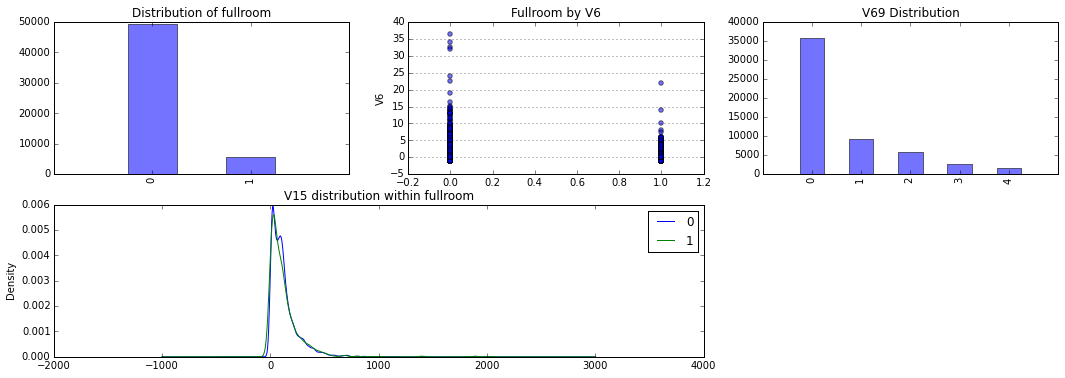

In [4]:
#使用pandas 读取数据
p = pd.read_csv('train.txt',sep= ' ')
# 可视化
fig = plt.figure(figsize = (18,6), dpi = 1600)
alpha = alpha_scatterplot = 0.2
alpha_bar_chart = 0.55

ax1 = plt.subplot2grid((2,3), (0,0))
p.isfullroom.value_counts().plot(kind = 'bar', alpha = alpha_bar_chart)
ax1.set_xlim(-1,2)
plt.title("Distribution of fullroom")

plt.subplot2grid((2,3),(0,1))
plt.scatter(p.isfullroom, p.V6, alpha = alpha_bar_chart)
plt.ylabel("V6")
plt.grid(b = True, which='major', axis = 'y')
plt.title("Fullroom by V6")

ax3 = plt.subplot2grid((2,3),(0,2))
p.V68.value_counts().plot(kind = "bar", alpha = alpha_bar_chart)
ax3.set_xlim(-1, len(p.V69.value_counts())+1)
plt.title("V69 Distribution")

plt.subplot2grid((2,3),(1,0), colspan = 2)
p.V15[p.isfullroom == 0].plot(kind = 'kde')
p.V15[p.isfullroom == 1].plot(kind = 'kde')
plt.xlabel = "V15"
plt.title("V15 distribution within fullroom")
plt.legend(('0','1'),loc = 'best')

## 2. 数据采样

可以看到数据很不平衡，正例样本远远小于负样本，这会使得常见的机器学习模型不能正常工作。处理这种问题的方法主要有以下几种：
1. 降采样，对负样本进行降采样，使得负样本数和正样本数平衡，但这会丢失了许多数据，同时采样的方法也会影响效果
2. 过采样，对正样本进行过采样，如对正样本拷贝
3. 对模型进行处理，如在梯度下降的时候正例更新次数为负例的n倍

下面会对各种方法进行对比。

In [5]:
def DownSample(data, y):
    pos = []
    neg = []
    s = y.shape[0]
    for i in range(s):
        if(y[i] == 1):
            pos.append(i)
    
    pos_size = len(pos)
    x = 0
    while (True):
        i = np.random.randint(0, s)
        if(y[i] == 0 and x < pos_size):
            neg.append(i)
            x += 1
        elif(y[i] == 1):
            continue
        elif(x >= pos_size):
            break
    pos = np.array(pos)
    neg = np.array(neg)
    print neg.shape
    res = np.concatenate((pos, neg))
    data = np.concatenate((data, y.reshape((-1,1))), axis = 1)
    data = data[res]
    np.random.shuffle(data)
    return data[:,:-1],data[:,-1]

In [6]:
from sklearn.cluster import KMeans
def DownSample_KMeans(data, y):
    pos = []
    neg = []
    s = y.shape[0]
    for i in range(s):
        if(y[i] == 1):
            pos.append(i)
        else:
            neg.append(i)
    
    pos_size = len(pos)
    
    pos = np.array(pos)
    pos_data = data[pos]
    pos_data = np.concatenate((pos_data, np.ones((pos_data.shape[0],1))), axis = 1)
    neg = np.array(neg)
    neg_data = data[neg]
    
    kmeans = KMeans(n_clusters = pos_size).fit(neg_data)
    
    centers = kmeans.cluster_centers_
    centers = np.concatenate((centers, np.zeros((centers.shape[0],1))), axis = 1)

    data_ = np.concatenate((pos_data, centers), axis = 0)
    np.random.shuffle(data_)
    
    return data_[:, :-1], data_[:, -1]

In [7]:
def UpSample(data, y):
    pos_idx = []
    neg_idx = []
    for i in range(y.shape[0]):
        if(int(y[i]) == 1):
            pos_idx.append(i)
        else:
            neg_idx.append(i)
    data = np.concatenate((data,y.reshape(-1,1)), axis = 1)
    
    pos_idx = np.array(pos_idx)
    pos_train_idx = pos_idx[:-1000]
    pos_val_idx = pos_idx[-1000:]
    
    pos_train_data = data[pos_train_idx]

    pos_train_data_ = pos_train_data
    for i in range(8):
        pos_train_data = np.concatenate((pos_train_data, pos_train_data_), axis = 0)
    train_num = pos_train_data.shape[0]
    pos_val = data[pos_val_idx]

    
    neg_idx = np.array(neg_idx)
    neg_train_idx = neg_idx[:train_num]
    neg_val_idx = neg_idx[train_num:]
    


    neg_train = data[neg_train_idx]
    neg_val = data[neg_val_idx]
    
    train = np.concatenate((pos_train_data, neg_train), axis = 0)
    val = np.concatenate((pos_val, neg_val), axis = 0)
    
    np.random.shuffle(train)
    np.random.shuffle(val)
    return train[:,:-1], train[:, -1], val[:, :-1], val[:, -1]

In [8]:
def Kfold_UpSample(data, y, k):
    pos = []
    neg = []
    s = y.shape[0]
    for i in range(s):
        if(y[i] == 1):
            pos.append(i)
        else:
            neg.append(i)
    pos = np.array(pos)
    pos_size = pos.shape[0]
    
    res_X = np.zeros((k, pos_size*2, data.shape[1]))
    res_y = np.zeros((k, pos_size*2))
    
    data = np.concatenate((data, y.reshape((-1,1))), axis = 1)    
    for i in range(k):
        x = 0.0
        while (True):
            i = np.random.randint(0, s)
            if(y[i] == 0 and x < pos_size):
                neg.append(i)
                x += 1
            elif(y[i] == 1):
                continue
            elif(x >= pos_size):
                break

        neg = np.array(neg)
        res = np.concatenate((pos, neg))
        ifold = data[res]
        np.random.shuffle(ifold)
        res_X[i] = ifold[:,:-1]
        res_y[i] = ifold[:, -1]
    return res_X, res_y
    

## 3.特征选择

数据共有73维的数字特征，2个类别特征经过OneHotEncoder后有13维，共有86个维度。考虑对这些特征进行选择，特征选择的方法主要有以下几种：
1. 移除方差较小的特征
2. 卡方检验选择得分较高的特征的方法
3. 基于模型的特征选择
4. 使用PCA降维

下面是几种方法的实现代码，具体参数需要后面继续调整。

numeric feature size =  (55081, 73)
category feature size =  (55081, 13)


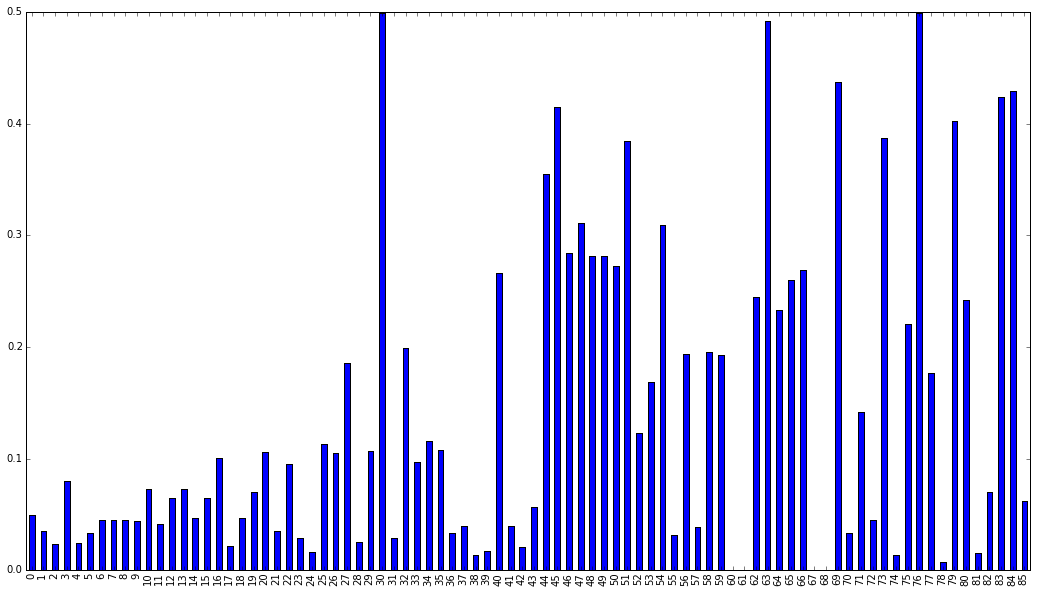

In [9]:
# 各个维度的方差对比，数据被scale到0，1之间

fig = plt.figure(figsize = (18,10), dpi = 1600)
data_set, labels = FE()
min_max_scaler = preprocessing.MinMaxScaler()
data_set_MIN_MAX = min_max_scaler.fit_transform(data_set)
var = np.std(data_set_MIN_MAX, axis = 0)
s = pd.Series(var)
s.plot(kind='bar')

In [10]:
#卡方检验
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def SelectTopK(X, y, K):
    X_new = SelectKBest(chi2, k=K).fit_transform(X, y)
    return X_new, y

In [11]:
# 基于模型的特征选择
from sklearn import feature_selection
def SelectByModel(model, X, y):
    model.fit(X, y)
    select = feature_selection.SelectFromModel(model, prefit=True)
    X_new = model.transform(X)
    return X_new, y

## 4. 模型训练

这里用了三种分类器模型：
1. SVM，用了sklearn实现的SVC
2. LG， 用了sklearn实现的LogisticRegression
3.  GBM (boosted trees) ， 用了开源代码xgboost实现的GBM


In [12]:
# Try SVM 
new_data , y = SelectTopK(data_set_MIN_MAX, labels, 40)
DS_data, DS_labels = DownSample(data_set_MIN_MAX, labels)
train_X = DS_data[:7000,:]
train_y = DS_labels[:7000]
val_X = DS_data[7000:, :]
val_y = DS_labels[7000:]
classifier = SVC(C = 1, gamma=0.001, class_weight={0:1, 1:1})
classifier.fit(train_X, train_y)
predicted = classifier.predict(val_X)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(val_y, predicted)))

(5657,)
Classification report for classifier SVC(C=1, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.60      0.68      0.64      2152
        1.0       0.63      0.55      0.59      2162

avg / total       0.61      0.61      0.61      4314




In [38]:
# 对SVM调差
from sklearn.grid_search import GridSearchCV
clf =GridSearchCV(classifier,
                   {'C': [100,1000,10000]},verbose=1)
clf.fit(DS_data,DS_labels)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min finished


0.709121442461
{'C': 10000}


In [28]:
#Try Xgboost
import xgboost as xgb
new_data , y = SelectTopK(data_set_MIN_MAX, labels, 50)
DS_data, DS_labels = DownSample(data_set_MIN_MAX, labels)
train_X = DS_data[:7000,:]
train_y = DS_labels[:7000]
val_X = DS_data[7000:, :]
val_y = DS_labels[7000:]

gbm = xgb.XGBClassifier(max_depth=8, n_estimators=1000, learning_rate=0.01,scale_pos_weight=0.89,
                        min_child_weight=1, objective='binary:logistic', base_score = 0.5).fit(train_X, train_y, early_stopping_rounds=10,eval_metric="auc", eval_set=[(val_X, val_y)])
predictions = gbm.predict(val_X)
false_pos = 0.0
true_pos = 0.0
false_neg = 0.0
true_neg = 0.0
for i in range(predictions.shape[0]):
    if(int(val_y[i]) == 1):
        if(predictions[i] == 1):
            true_pos += 1.0
        else:
            false_neg += 1.0
    else:
        if(predictions[i] == 0):
            true_neg += 1.0
        else:
            false_pos += 1.0
            
                    
print 'precison = ', true_pos/(true_pos + false_pos)
print 'recall = ' , true_pos/(true_pos + false_neg)
print true_pos, false_neg, false_pos,true_neg

(5657,)
precison =  0.748043052838
recall =  0.709512761021
1529.0 626.0 515.0 1644.0


对XGboost模型进行调参

In [34]:

from sklearn.grid_search import GridSearchCV
 
clf =GridSearchCV(gbm,
                   {'max_depth': [8,9,10],
                    'n_estimators': [100,200,300,800,1000]}, verbose=1)
clf.fit(DS_data,DS_labels)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.2min finished


0.744564256673
{'n_estimators': 800, 'max_depth': 8}


In [14]:
# try LG 
new_data , y = SelectTopK(data_set_MIN_MAX, labels, 40)
DS_data, DS_labels = DownSample(data_set_MIN_MAX, labels)
train_X = DS_data[:7000,:]
train_y = DS_labels[:7000]
val_X = DS_data[7000:, :]
val_y = DS_labels[7000:]
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
clf.fit(train_X, train_y)
predicted = clf.predict(val_X)
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(val_y, predicted)))

(5657,)
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.69      0.72      0.70      2147
        1.0       0.71      0.68      0.69      2167

avg / total       0.70      0.70      0.70      4314




In [ ]:
from sklearn.grid_search import GridSearchCV
clf =GridSearchCV(clf,
                   {'C': [1,10,100,1000]},verbose=1)
clf.fit(DS_data,DS_labels)
print(clf.best_score_)
print(clf.best_params_)

In [15]:
def modelfit(alg, data, labels,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(data, labels,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(data)
    dtrain_predprob = alg.predict_proba(data)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore())
    feat_imp.sort(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.922
AUC Score (Train): 0.980198


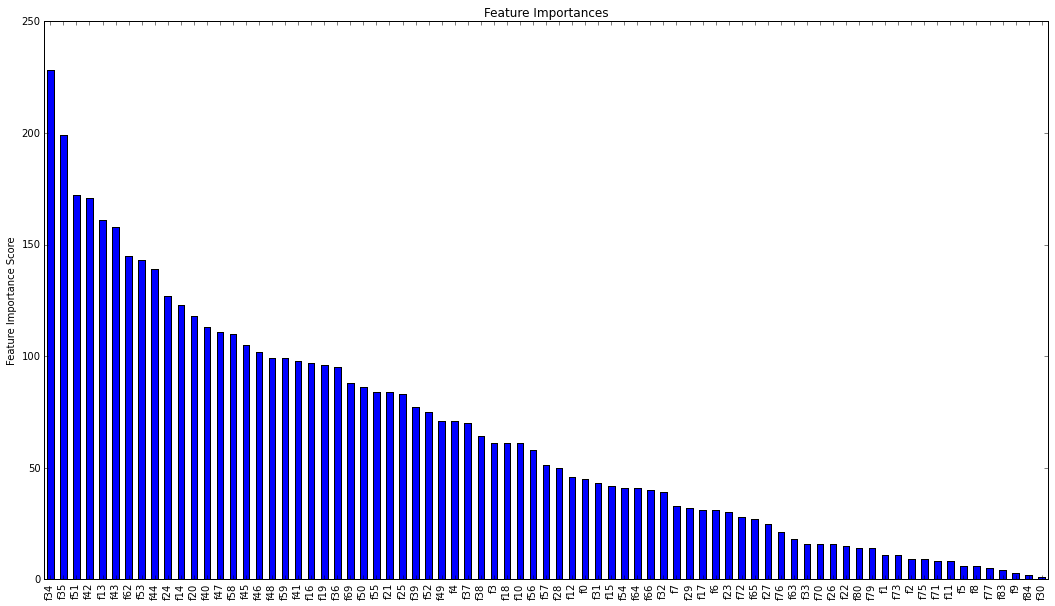

In [24]:
fig = plt.figure(figsize = (18,10), dpi = 1600)
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=0.89,
 objective= 'binary:logistic',
 nthread=14,
 seed=27)
modelfit(xgb1, train_X, train_y)

## 5. 模型融合
将GBM和SVC、LG的结果融合，采用投票的方式。

In [39]:
from sklearn.ensemble import VotingClassifier
eclf1 =VotingClassifier(estimators=[('svm', classifier), ('lf', clf), ('xgb', gbm)], voting='hard', weights=[1,1,2])

In [40]:
eclf1.fit(train_X, train_y)
predicted = clf.predict(val_X)
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(val_y, predicted)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.4s finished


Classification report for classifier GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [100, 1000, 10000]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1):
             precision    recall  f1-score   support

        0.0       0.72      0.75      0.73      2159
        1.0       0.74      0.70      0.72      2155

avg / total       0.73      0.73      0.73      4314




In [41]:
def FE():
    p = pd.read_csv('test.txt',sep= ' ')
    data_prim = p.as_matrix()
    data = data_prim[:,1:59]
    V60 = OneHotEncoder(data_prim[:,59])
    #data = np.concatenate((data, V60), axis = 1)
    data = np.concatenate((data, data_prim[:,60:68]), axis = 1)
    V69 = OneHotEncoder(data_prim[:,68])
    #data = np.concatenate((data, V69), axis = 1)
    data = np.concatenate((data, data_prim[:,69:76]), axis = 1)
    print 'numeric feature size = ', data.shape
    OneHotFeature = np.concatenate((V60,V69), axis = 1)
    print 'category feature size = ', OneHotFeature.shape
    data = np.concatenate((data, OneHotFeature), axis = 1)
    return data.astype('float')

In [43]:
test_data = FE()
result = eclf1.predict(test_data)

numeric feature size =  (43934, 73)
category feature size =  (43934, 13)


In [49]:
p = pd.read_csv('test.txt',sep= ' ')
data_prim = p.as_matrix()
id = data_prim[:,0]
with open('result.txt', 'wt') as f:
    for i in range(id.shape[0]):
        f.writelines(str(id[i])+' '+str(int(result[i]))+'\n')

## 6. 总结

最后没有在isfullroom = 1时达到98%的precision，也就没有优化recall。分析原因
1. 可能是我对特征的选择和处理还有欠缺
2. 在处理非平衡数据这方面采取了简单的降采样和升采样方法，都没能将结果提升到理想程度，采取了对负样本聚类的降采样方法，也没有什么大的提升。
3. 对数据的理解还不足

